# import library 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
%cd "/content/drive/My Drive"

/content/drive/My Drive


In [ ]:
# download thư viện mmcv-full cho mmdetection và donwload mmdetection


# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 63.6MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 245kB 7.7MB/s 
     |████████████████████████████████| 194kB 17.1MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.1.2-cp36-cp36m-linux_x86_64.whl size=17153720 sha256=a7bf77db355046ee3e2263f476947bfa6e138409daf63f87e29ececea154df1f
  Stored in directory: /root/.cache/pip/wheels/d8/1b/e5/a291cfee98447e0126133246510d01ac2ba5225aac9c2eac2e
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 13127, done.
remote: Total 13127 (delta 0), reused 0 (del

In [ ]:
# kiểm tra xem việc thiết lập có ok hay chưa

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.4.0
10.1
GCC 7.5


In [ ]:
import copy
import os.path as osp
import mmcv
import numpy as np
import pickle
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# config gốc và checkpoint_file

In [ ]:
config_file = '/content/drive/My Drive/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/drive/My Drive/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# tạo module để đọc file về middle format

In [ ]:
DATASETS.register_module()
class flick_dataset5(CustomDataset):

    CLASSES = ('Car', )

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:5]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

# Modify the config

In [ ]:
cfg = Config.fromfile('config_file')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'flick_dataset5'
cfg.data_root = '/content/drive/My Drive/mmdetection/flick/'

cfg.data.test.type = 'flick_dataset5'
cfg.data.test.data_root = '/content/drive/My Drive/mmdetection/flick/'
cfg.data.test.ann_file = '/content/drive/My Drive/mmdetection/flick/train.txt'
cfg.data.test.img_prefix = '/content/drive/My Drive/mmdetection/flick/training/image_2'

cfg.data.train.type = 'flick_dataset5'
cfg.data.train.data_root = '/content/drive/My Drive/mmdetection/flick/'
cfg.data.train.ann_file = '/content/drive/My Drive/mmdetection/flick/train.txt'
cfg.data.train.img_prefix = '/content/drive/My Drive/mmdetection/flick/training/image_2'

cfg.data.val.type = 'flick_dataset5'
cfg.data.val.data_root = '/content/drive/My Drive/mmdetection/flick/'
cfg.data.val.ann_file = '/content/drive/My Drive/mmdetection/flick/val.txt'
cfg.data.val.img_prefix = '/content/drive/My Drive/mmdetection/flick/training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/My Drive/mmdetection/tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

# train

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))


2020-09-06 06:03:09,523 - mmdet - INFO - load model from: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


2020-09-06 06:03:10,319 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-09-06 06:06:05,727 - mmdet - INFO - load checkpoint from /content/drive/My Drive/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2020-09-06 06:06:08,008 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
2020-09-06 06:06:08,016 - mmdet - INFO - Start running, host: root@48e22b43f3f3,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 200/200, 8.3 task/s, elapsed: 24s, ETA:     0s

2020-09-06 06:42:55,389 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| Car   | 295 | 439  | 0.661  | 0.587 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.587 |
+-------+-----+------+--------+-------+
2020-09-06 06:42:55,391 - mmdet - INFO - Epoch(val) [12][304]	mAP: 0.5872


# testing: quên chỉnh tên class về logo

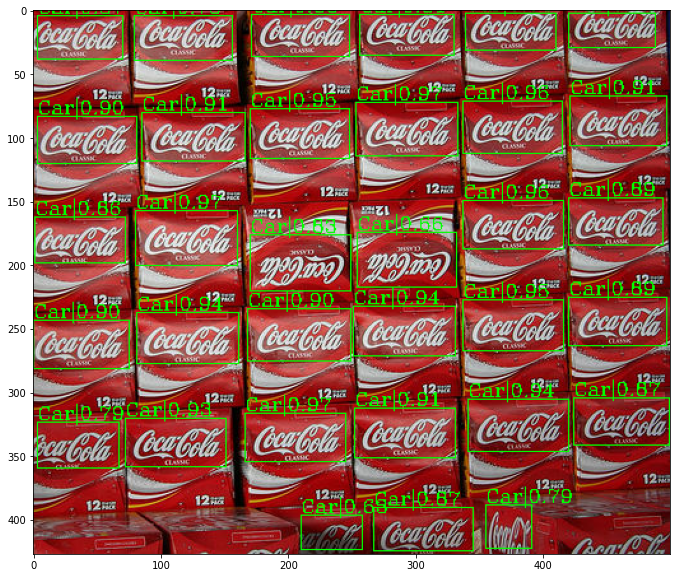

In [ ]:
img = mmcv.imread('/content/drive/My Drive/mmdetection/flick/training/image_2/2534155497.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## pickle

In [ ]:
import pickle
pkl_filename = "/content/drive/My Drive/flick_dataset_preprocessing/model/model_1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## torch.save

In [ ]:
PATH = '/content/drive/My Drive/flick_dataset_preprocessing/model/model_1.pth'
torch.save(model, PATH)